In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16
import matplotlib.pyplot as plt
from torchsummary import summary

# Device config
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Load CIFAR-10 data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG-16 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Load a small subset for faster processing
subset_size = 5  # You can change this
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
subset_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dataset, list(range(subset_size))),
    batch_size=10, shuffle=False)

In [3]:
from torchsummary import summary

# Load pretrained VGG-16
model = vgg16(pretrained=True)
summary(model, input_size=(3, 512,512))

/home/vishvaditya/miniconda3/envs/advance_cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vishvaditya/miniconda3/envs/advance_cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

In [5]:
## Write the code to extract features from the penultimate layer:
## YOUR CODE ##

def extractFeatures(model, subset_loader):
    model.eval()

    # Remove the last classification layer
    feature_extractor = nn.Sequential(*list(model.classifier.children())[:-1])
    model.classifier = feature_extractor

    # Send model to device
    model = model.to(device)

    # Extract features
    features = []
    with torch.no_grad():
        for images, _ in subset_loader:
            images = images.to(device)
            out = model(images)  
            features.append(out.cpu())

    # Stack all features
    features = torch.cat(features, dim=0)
    return features

penultimate_features = extractFeatures(model, subset_loader)

print(f"Feature shape from penultimate layer: ", penultimate_features.shape)

Feature shape from penultimate layer:  torch.Size([5, 4096])


In [20]:
## Write the code to visualize feature maps:

## YOUR CODE

def getFeatureMaps(model, layer, input):
    model.eval()
    layer_to_visualize = model.features[layer]

    # Forward hook to capture the feature maps
    activation = {}

    def getActivation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # Register hook
    hooker = layer_to_visualize.register_forward_hook(getActivation(str(layer)))

    x = model(input)
    hooker.remove()

    # Get feature maps
    feature_map = activation[str(layer)].squeeze().cpu()  # Shape: [num_channels, H, W]

    # Plot the feature maps
    num_feature_maps = min(16, feature_map.size(0))  # Display up to 16 feature maps
    return num_feature_maps, feature_map


image, label = train_dataset[69]
image_tensor = image.unsqueeze(0).to(device)

num_feature_maps, feature_map = getFeatureMaps(model, 1, image_tensor)
print(feature_map.shape, num_feature_maps)

torch.Size([64, 224, 224]) 16


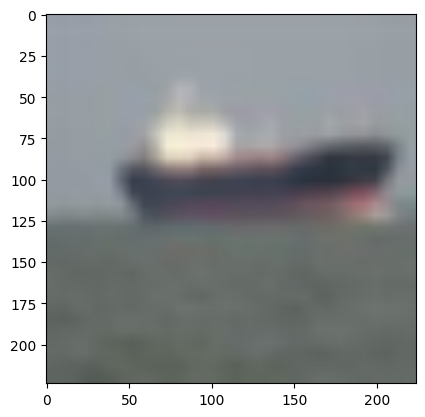

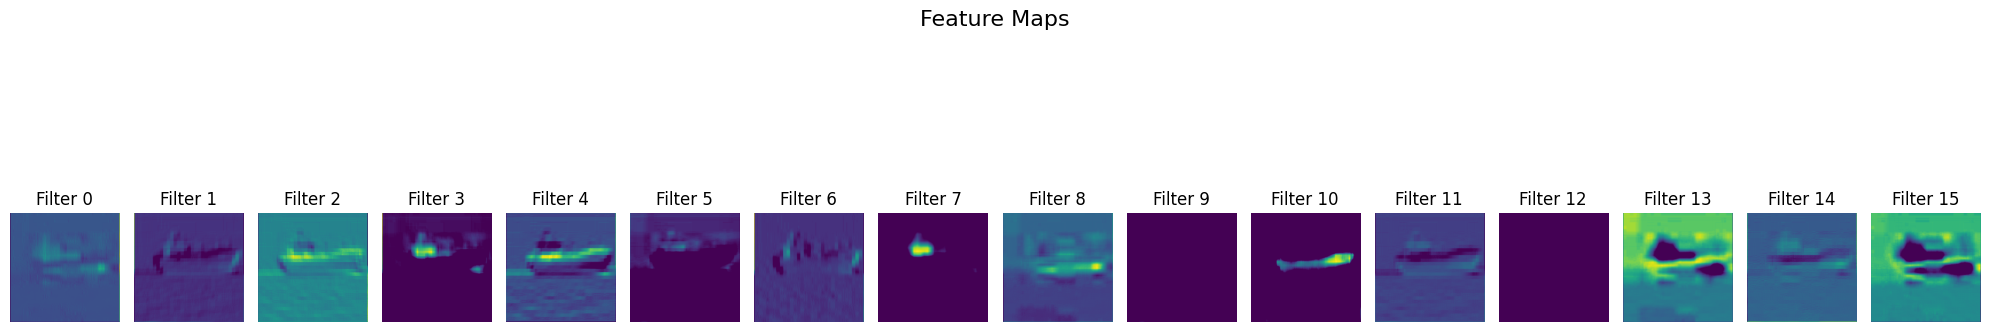

In [21]:
## Display results on a randomly chosen image ..

def displayImage(image):
    # Unnormalize the image
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    unnormalized_image = image * std + mean

    np_image = unnormalized_image.permute(1, 2, 0).cpu().numpy()
    plt.imshow(np_image)
    plt.show()

def visualizeFeatureMaps(num_feature_maps, feature_map):
    fig, axs = plt.subplots(1, num_feature_maps, figsize=(20, 5))

    for i in range(num_feature_maps):
        axs[i].imshow(feature_map[i], cmap='viridis')
        axs[i].axis('off')
        axs[i].set_title(f'Filter {i}')

    plt.suptitle("Feature Maps", fontsize=16)
    plt.tight_layout()
    plt.show()

displayImage(image)
visualizeFeatureMaps(num_feature_maps, feature_map)